# Finding Chemical Signatures with Unsupervised Learning

-------

## 1. Introduction


In materials sciences, the chemical structure of a material can be determined by measuring its interaction with light. Different frequencies of light (colors) will interact differently with every material, becoming features of its chemical structure. A single observation will be then an n-dimensional array, where each array element is the measured intensity of a frequency. In the domain of materials science, every observation or data point, is a spectrum. 

This notebook shows the use of unsupervised learning to extract latent (hidden) chemical signatures from a dataset describing a chemical process. The dataset is a sequence of Raman spectra measured during the formation of a single crystal of glycine from a solution. In simple words, the birth of a crystal. 

This notebook is inspired in the following published paper: https://doi.org/10.1073/pnas.2122990119

## 2. Data Description

### Dataset Overview

- The dataset is a sequence of Raman spectra from a glycine crystallization process. 
- It is presented as numerical tabular data, with 990 features and 73 instances. Each data point, or spectra, is an array with 990-dimensions.
 
- Source of dataset: DOI: **https://doi.org/10/gp9f7w**

### Data Dictionary

- Each feature is a Wavenumber (frequency) in the Raman spectrum. 

- The first column is the time tag at which the data point was recorded.

## 3. Problem Statement and Objectives

### Problem Statement

In materials science, understanding the chemical structure of a material involves analyzing its interaction with light, which generates spectral data. We need to uncover hidden chemical signatures from Raman spectra data collected during the crystallization of glycine from a solution.

### Objectives 

1) **Determine the Optimum Number of Chemical Signatures:** Identify the optimal number of distinct spectra that best describe the chemical process during crystallization.
2) **Extract Main Chemical Signatures:** Isolate the primary chemical signatures representing different chemical species involved in the crystallization process, with a focus on the nucleation phase.
3) **Describe the Behavior of Each Component:** Analyze and describe how each identified component behaves throughout the crystallization process.

4) **Ensure Interpretability:** Ensure that the latent chemical signatures extracted from the data are interpretable and provide clear insights into the chemical process.


## 4. Import Data and Libraries 

### Import Necessary Libraries and Dependencies

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA, TruncatedSVD, NMF
#from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
#from sklearn.neighbors import kneighbors_graph
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


### Add Project Root Directory to the PYTHONPATH

In [2]:
# Add the project root directory to the PYTHONPATH
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

### Load Data

- The data (previously reformatted by another python script) is loaded

In [3]:
# Load the CSV file into a DataFrame
spectra_dataset_with_time = pd.read_csv('../data/processed/Raman_spectra_data_reformatted.csv')

### Initial Exploration

In [4]:
# Preview the original dataset
spectra_dataset_with_time.head()

,time,202.4228134130135,206.7974042247297,211.17166349874606,215.54628058033632,219.91883849213264,224.28933868770036,228.65985068763985,233.03037302343,237.39677198449863,...,3677.859080076547,3680.3954918731943,3682.9299108806954,3685.4618821298736,3687.991635850669,3690.51917384453,3693.0442698666247,3695.567381877552,3698.088283551384,3700.6067488644203
0,0.00000,3.095591e+06,2.558683e+06,2.484597e+06,3.076788e+06,2.742008e+06,3.410274e+06,2.837431e+06,2.827157e+06,2.700712e+06,...,1.531710e+06,2.451559e+06,1.979422e+06,2.400635e+06,1.051725e+06,1.990179e+06,1.534792e+06,2.096788e+06,6.143272e+05,1.466098e+06
1,0.04562,2.806283e+06,2.558683e+06,2.195017e+06,3.076788e+06,3.031861e+06,2.830295e+06,2.837431e+06,2.827157e+06,2.700712e+06,...,1.531710e+06,1.576002e+06,1.979422e+06,1.524491e+06,2.366381e+06,1.990179e+06,1.534792e+06,1.219471e+06,1.491938e+06,1.466098e+06
2,0.09124,2.806283e+06,2.269239e+06,3.063757e+06,2.787072e+06,2.742008e+06,3.120285e+06,3.417682e+06,3.117419e+06,2.991111e+06,...,1.969342e+06,2.013781e+06,1.541497e+06,1.524491e+06,1.928163e+06,1.551814e+06,1.534792e+06,2.096788e+06,1.930743e+06,1.905050e+06
3,0.13686,2.806283e+06,2.848126e+06,3.353337e+06,2.787072e+06,3.321713e+06,3.120285e+06,2.547305e+06,2.246632e+06,2.119913e+06,...,1.531710e+06,2.013781e+06,1.979422e+06,2.400635e+06,1.489944e+06,1.113448e+06,1.534792e+06,1.219471e+06,1.491938e+06,1.466098e+06
4,0.18248,3.384898e+06,2.269239e+06,3.063757e+06,3.076788e+06,2.742008e+06,2.250317e+06,2.257179e+06,2.827157e+06,3.281510e+06,...,1.531710e+06,2.013781e+06,1.541497e+06,1.524491e+06,1.928163e+06,1.551814e+06,1.973304e+06,2.096788e+06,1.930743e+06,1.905050e+06


In [5]:
# Get the shape of the dataset
spectra_dataset_with_time.shape

(73, 990)

**Insight**: The shape of the dataset is 73 data points (rows) of 990-dimensions or features (columns).  

## 5. Data Cleaning and Pre-Processing

### Separate Features and Timestamps

In [6]:
# separate the spectra and timestamp
spectra_dataset = spectra_dataset_with_time.drop('time', axis=1, inplace=False)
timestamps = spectra_dataset_with_time.iloc[:,0].to_numpy()

#preview the dataset without timestamps
spectra_dataset.head()

,202.4228134130135,206.7974042247297,211.17166349874606,215.54628058033632,219.91883849213264,224.28933868770036,228.65985068763985,233.03037302343,237.39677198449863,241.76524738888475,...,3677.859080076547,3680.3954918731943,3682.9299108806954,3685.4618821298736,3687.991635850669,3690.51917384453,3693.0442698666247,3695.567381877552,3698.088283551384,3700.6067488644203
0,3.095591e+06,2.558683e+06,2.484597e+06,3.076788e+06,2.742008e+06,3.410274e+06,2.837431e+06,2.827157e+06,2.700712e+06,2.498608e+06,...,1.531710e+06,2.451559e+06,1.979422e+06,2.400635e+06,1.051725e+06,1.990179e+06,1.534792e+06,2.096788e+06,6.143272e+05,1.466098e+06
1,2.806283e+06,2.558683e+06,2.195017e+06,3.076788e+06,3.031861e+06,2.830295e+06,2.837431e+06,2.827157e+06,2.700712e+06,2.789144e+06,...,1.531710e+06,1.576002e+06,1.979422e+06,1.524491e+06,2.366381e+06,1.990179e+06,1.534792e+06,1.219471e+06,1.491938e+06,1.466098e+06
2,2.806283e+06,2.269239e+06,3.063757e+06,2.787072e+06,2.742008e+06,3.120285e+06,3.417682e+06,3.117419e+06,2.991111e+06,3.370216e+06,...,1.969342e+06,2.013781e+06,1.541497e+06,1.524491e+06,1.928163e+06,1.551814e+06,1.534792e+06,2.096788e+06,1.930743e+06,1.905050e+06
3,2.806283e+06,2.848126e+06,3.353337e+06,2.787072e+06,3.321713e+06,3.120285e+06,2.547305e+06,2.246632e+06,2.119913e+06,2.498608e+06,...,1.531710e+06,2.013781e+06,1.979422e+06,2.400635e+06,1.489944e+06,1.113448e+06,1.534792e+06,1.219471e+06,1.491938e+06,1.466098e+06
4,3.384898e+06,2.269239e+06,3.063757e+06,3.076788e+06,2.742008e+06,2.250317e+06,2.257179e+06,2.827157e+06,3.281510e+06,2.789144e+06,...,1.531710e+06,2.013781e+06,1.541497e+06,1.524491e+06,1.928163e+06,1.551814e+06,1.973304e+06,2.096788e+06,1.930743e+06,1.905050e+06


### Extract Wavenumbers
- Extract as well the wavenumbers that will be used to plot the spectra and that come from the column labels. 

In [7]:
# Extract wavenumbers from the DataFrame column names
wavenumbers = spectra_dataset.columns.astype(float)

### Filter Random Noise and Low Variance Components 

- First we use Singular Value Decomposition (SVD) to understand how many components carry most of the variance.

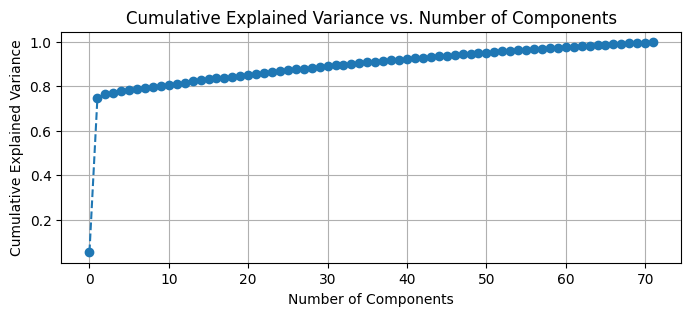

In [8]:

# Create a svd pipeline for filtering
svd_evaluation_pipeline = Pipeline([
    ('svd', TruncatedSVD()),
])

# Define the n_components parameter
svd_evaluation_pipeline.set_params(svd__n_components=min(spectra_dataset.shape) - 1)

# Fit the pipeline
svd_evaluation_pipeline.fit(spectra_dataset)

# Explained variance ratio
explained_variance_ratio = svd_evaluation_pipeline['svd'].explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot cumulative explained variance
plt.figure(figsize=(8, 3))
plt.plot(cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

**Insight:**  80% of the variance is in just 10 components. 

- Setting a 80% threshold, filtering is performed by truncated SVD: Truncating at 10 components and performing a reconstruction. 

In [9]:
# Create a svd pipeline for filtering
svd_filtering_pipeline = Pipeline([
    ('svd', TruncatedSVD(n_components=10)),
])

# Fit the svd pipeline
spectra_dataset_svd = svd_filtering_pipeline.fit_transform(spectra_dataset)
# Reconstruct the matrix
spectra_dataset_svd_reconstructed_matrix = svd_filtering_pipeline.inverse_transform(spectra_dataset_svd)
# Convert the reconstructed matrix back to a DataFrame with the same column names
spectra_dataset_svd_filtered = pd.DataFrame(spectra_dataset_svd_reconstructed_matrix, columns=spectra_dataset.columns)

### Rescale Data
- All the dataset is rescaled to values inside the 0-1 range.


In [10]:
# Function to rescale a dataframe from 0 to 1
def rescale(df):
        # Calculate global min and max
    global_min = df.min().min()
    global_max = df.max().max()

    # Apply Min-Max scaling
    df_normalized = (df - global_min) / (global_max - global_min)
    return df_normalized
    
# Row-wise normalization
spectra_dataset_svd_filtered_normalized = rescale(spectra_dataset_svd_filtered)

# Extract the global stats of the whole dataset (columns combined)
spectra_dataset_svd_filtered_normalized.stack().describe()

count    72197.000000
mean         0.077827
std          0.072358
min          0.000000
25%          0.029349
50%          0.044519
75%          0.104635
max          1.000000
dtype: float64

**Observation:** The dataset was correctly scaled. 

## 6. Exploratory Data Analysis (EDA)

### Visualize the Normalized Dataset 

- A heatmap of the dataset helps visualize how different parts of the spectrum show different intensity features during different states:
    1)  The features are broad while the sample is in a liquid state (solution).
    2)  There is a distinct and short transition region which matches the nucleation or birth of a crystal.
    3)  The final state is characterized by sharp intensity features when the sample reaches the solid state (crystal).

- Red lines are drawn at meaningful times, from where 2D plots of the spectra are later extracted.

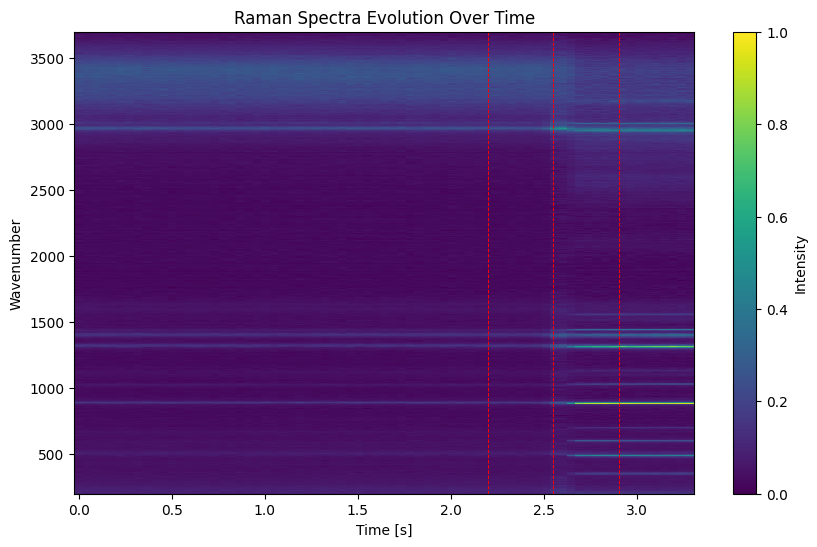

In [11]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create the heatmap
c = ax.pcolormesh(
    timestamps, 
    np.float32(spectra_dataset_svd_filtered_normalized.columns), 
    spectra_dataset_svd_filtered_normalized.T, 
    cmap='viridis', 
    shading='auto')

# Add labels and title
ax.set_xlabel('Time [s]')
ax.set_ylabel('Wavenumber')
ax.set_title('Raman Spectra Evolution Over Time')

# Define specific times to extract curves from the heatmap data
specific_times = [2.2,2.55,2.9]


# Add red vertical lines at specified times
for t in specific_times:
    ax.axvline(x=t, color='red', linestyle='--', linewidth = 0.7)

# Add colorbar
cbar = fig.colorbar(c, ax=ax)
cbar.set_label('Intensity')

# Show the plot
plt.show()

### Visualize Key Spectra
- Data points (spectra) at the marked red lines are extracted for visualization. 

- By inspecting the data, there seems to be **at least 2** evident chemical signatures from the initial and final state. 

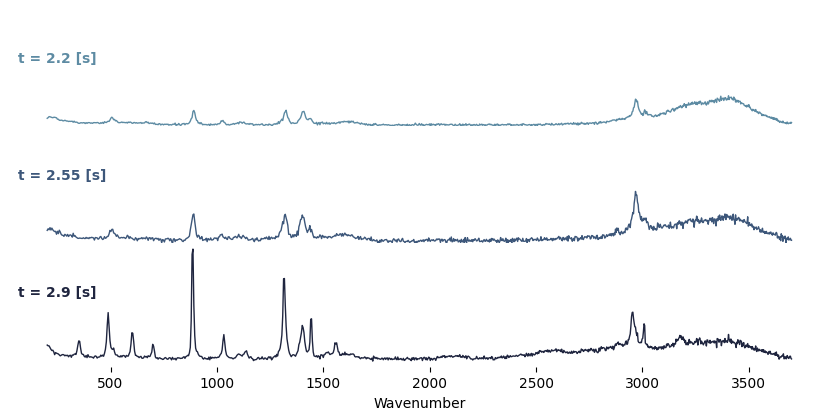

In [12]:
# Find the indexes of the defined times
specific_time_indexes = np.abs(timestamps[:, np.newaxis] - specific_times).argmin(axis=0)

# Create a DataFrame to hold the extracted curves
extracted_curves = pd.DataFrame()
for i, time_index in enumerate(specific_time_indexes):
    extracted_curves[f't = {specific_times[i]} [s]'] = spectra_dataset_svd_filtered_normalized.iloc[time_index, :]

# Reset index to use wavenumber as a column
extracted_curves['Wavenumber'] = np.float32(spectra_dataset_svd_filtered_normalized.columns)
extracted_curves = pd.melt(extracted_curves, id_vars='Wavenumber', var_name='Time', value_name='Intensity')

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(len(specific_time_indexes), rot=-.25, light=.5)
g = sns.FacetGrid(extracted_curves, row="Time", hue="Time", aspect=6, height=1.5, palette=pal)

# Draw the line plots
g.map(sns.lineplot, "Wavenumber", "Intensity", linewidth=1)

# Define and use a simple function to label the plot in axes coordinates
def label(wavenumber, intensity, color, label):
    ax = plt.gca()
    ax.text(0.01, .6, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes,size=10)

g.map(label, "Wavenumber", "Intensity")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-0.05)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

plt.show()


## 7. Clustering

- A Hierarchical clustering algorithm is used to understand the different classes of chemical signatures present in the dataset.

- Due to the rapid nature of the crystallization process, it may result in a strong class imbalance. Hierarchical clustering was selected for this reason. 

### Finding The Optimum Number of Clusters 
- A set of evaluation scores are computed and plotted for various cluster numbers to discover the optimum value:

    - Within-cluster sum of squares (WCSS) or "Elbow Curve": Where the optimum number of clusters is at the inflection point
    - Silhouette Score: We look for the maximum value
    - Calinski Harabasz Score: We look for the maximum value
    - Davies Bouldin Score: We look for the minimum value

Davies-Bouldin score omitted for point 1
Silhouette score omitted for point 1
Calinski-Harabasz score omitted for point 1


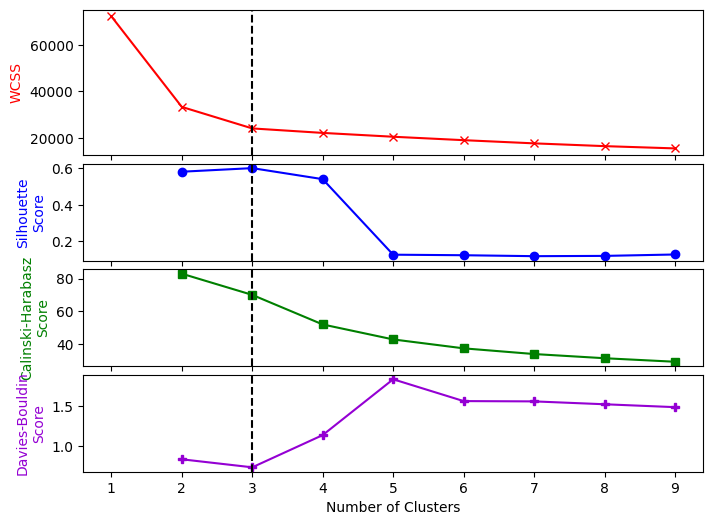

In [13]:
# Import code to run evaluation
from src import evaluation_metrics_hierarchical_clustering
# Run evaluation
evaluation_metrics_hierarchical_clustering.plot_hierarchical_clustering_evaluation_curves(spectra_dataset_svd_filtered_normalized,cluster_number_evaluation=3, cluster_number=range(1, 10))

**Insight:**  All curves, except the Calinski Harabasz, show that 3 clusters is the best choice.

### Visualization of Hierarchical Clustering

- Hierarchical clustering is used to cluster the data in 3 clusters.

In [14]:
# Create a clustering pipeline
hierarchical_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scale data (standarization)
    ('AgglomerativeClustering', AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward',connectivity=None))
])

# Fit the pipeline
hierarchical_pipeline.fit(spectra_dataset_svd_filtered_normalized)
# Extract labels and add 1 to match the original label range
hierarchical_labels = hierarchical_pipeline['AgglomerativeClustering'].labels_ + 1

- The original dataset is reduced to a 2-dimensional space by Principal Component Analysis (PCA).


In [15]:
# Create a PCA pipeline
PCA_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scale data (standardization)
    ('pca', PCA(n_components=2,random_state=42)),  # Reduce dimensions
])

# Fit the pipeline to the training data
PCA_projection = PCA_pipeline.fit_transform(spectra_dataset_svd_filtered_normalized) # outputs the projection of the data into 2 dimensions. 

- Clusters are visualized on the 2-dimensional representation by different colors. 

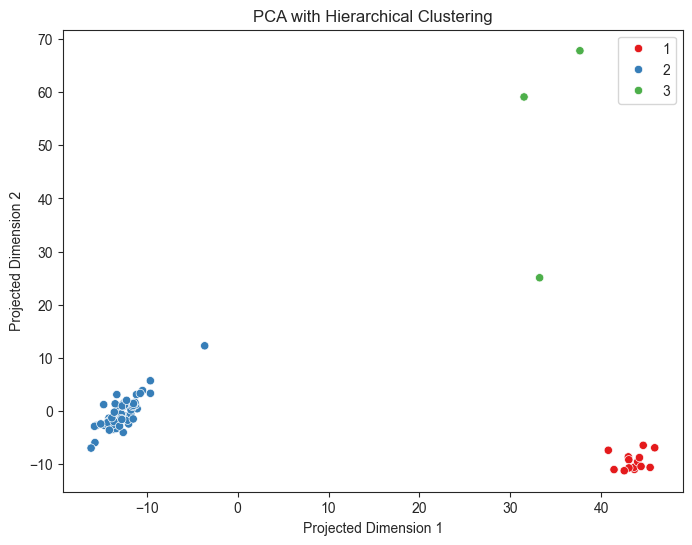

In [16]:
# Set the style of seaborn plot
sns.set_style("ticks")

# Create the scatter plot using seaborn
plt.figure(figsize=(8, 6))  # Adjust figure size if needed
sns.scatterplot(x=PCA_projection[:, 0], y=PCA_projection[:, 1], hue = hierarchical_labels, palette='Set1', legend=True)

# Set labels and title
plt.xlabel('Projected Dimension 1')
plt.ylabel('Projected Dimension 2')
plt.title('PCA with Hierarchical Clustering')

plt.show()

**Insights:**

- The visualization helps confirm the existence of 3 cluster classes.

- Few points belong to class 3 which belong too the period of nucleation ("crystal birth")

 

## 8. Dimensionality Reduction

- 3 cluster classes of distinct chemical signatures were already found. A complementary method is needed to extract the chemical signatures, that will be later used to understand the chemical structures.

- Along with reducing the number of dimensions or features of a dataset,  dimensionality reduction methods can be used to find the principal components or basis vectors describing its main variability. These methods can be used to separate the chemical signatures that describe the chemical process represented by the dataset. 


### Non-Negative Matrix Factorization

- NMF was chosen to maintain the interpretability: Raman spectra can only take non-negative values. 

- The number of components was set to 3 from the previous clustering results. 

In [17]:

# Create an NMF pipeline
NMF_pipeline = Pipeline([
    ('nmf', NMF(n_components=3,  
                init='nndsvd', 
                solver='cd',
                beta_loss='frobenius',
                tol=1e-4,
                random_state=0,
                max_iter=6000,
                shuffle=True))
])

# Fit the pipeline to the training data
NMF_pipeline.fit(spectra_dataset_svd_filtered_normalized)

# Extract the matrices from the fitted model
W = NMF_pipeline.named_steps['nmf'].transform(spectra_dataset_svd_filtered_normalized) # Reduced representation (Weights)
H = NMF_pipeline.named_steps['nmf'].components_ # Components

### Visualize NMF Reduced Representation (Weights)

- Visualize normalized 3-dimensional reduced representation: Component weights extracted from NMF as they evolve through time.

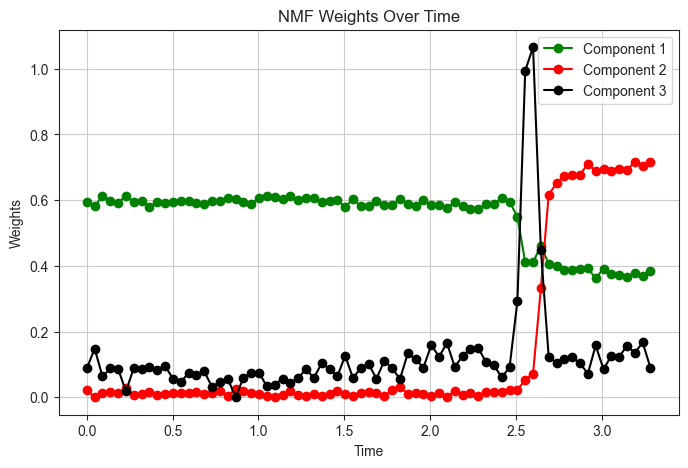

In [18]:
# Define colors of components
colors_NMF = ['green','red','black']

# Plot the weights over time
plt.figure(figsize=(8, 5))
for i in range(W.shape[1]):
    plt.plot(timestamps, W[:, i], color =colors_NMF[i], label=f'Component {i + 1}', marker='o')

plt.xlabel('Time')
plt.ylabel('Weights')
plt.title('NMF Weights Over Time')
plt.legend()
plt.grid(True)
plt.show()


- Each 3-dimensional data point (set of weights) is normalized so it adds up to 1 and plotted for better interpretability.

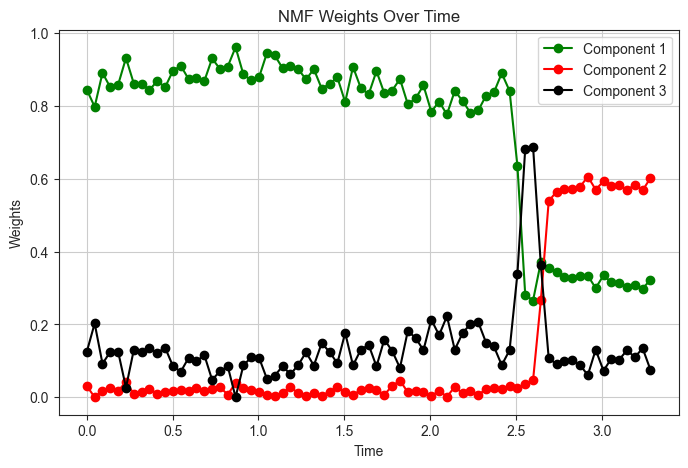

In [19]:
# Normalize rows of W to sum to 1 
W_sum = np.sum(W,axis=1,keepdims=True)
W_normalized = (W / W_sum)

# Plot the normalized weights over time
plt.figure(figsize=(8, 5))
for i in range(W_normalized.shape[1]):
    plt.plot(timestamps, W_normalized[:, i], color =colors_NMF[i], label=f'Component {i + 1}', marker='o')

plt.xlabel('Time')
plt.ylabel('Weights')
plt.title('NMF Weights Over Time')
plt.legend()
plt.grid(True)
plt.show()

**Insight:** Plotting the reduced representation through time help us understand how the chemical signatures evolve over time and gives valuable information to the researchers about the nature of the process. 

### Visualize NMF Components (Raman Chemical Signatures)
- The 3 components extracted by NMF are plotted.

- The components, or basis vectors, are the principal chemical signatures describing the process (Raman spectra).

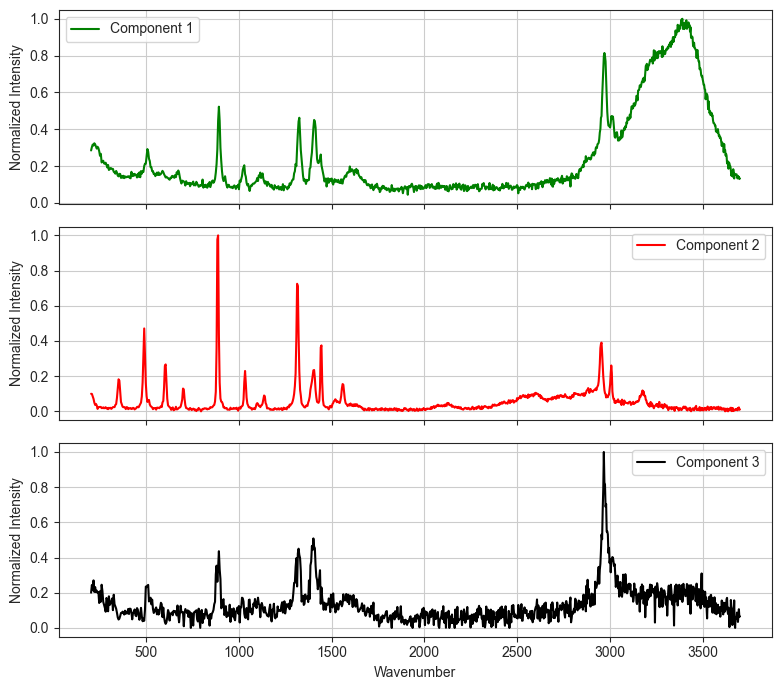

In [20]:

# Normalize each component of H to its maximum value
H_normalized = H / np.max(H, axis=1, keepdims=True)

# Plotting the three components as horizontal subplots
fig, axes = plt.subplots(3, 1, figsize=(8, 7), sharex=True)

for i in range(H_normalized.shape[0]):
    axes[i].plot(wavenumbers, H_normalized[i, :], color=colors_NMF[i], label=f'Component {i+1}')
    axes[i].set_ylabel('Normalized Intensity')
    axes[i].legend()
    axes[i].grid(True)

axes[2].set_xlabel('Wavenumber')

plt.tight_layout()
plt.show()



**Insights:** 

- The extracted components, when plotted against the wavenumbers, can be interpreted as Raman spectra. 
- Each of these components are signatures of a chemical species with certain structure. 

- These extracted Raman spectra will be used by materials specialists to understand the chemical changes during the formation of a crystal.  

### Further Validate the Optimum Number of NMF Components

- To verify that 3 components is the Optimum number, multiple NMF models where fitted for a range of number of components. The euclidean norm of the residuals was calculated for each model. 

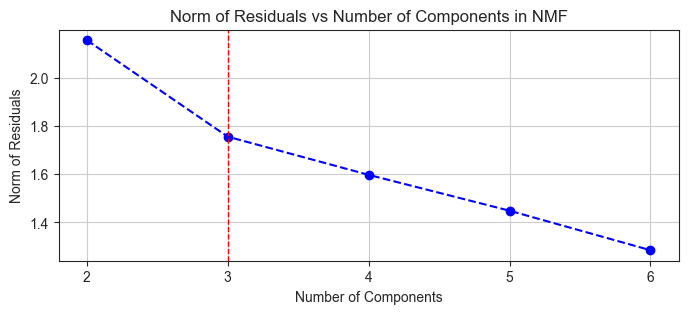

In [21]:
from src import evaluation_number_NMF_components

evaluation_number_NMF_components.evaluate_and_plot_nmf_component_number(spectra_dataset_svd_filtered_normalized, range(2, 7))


**Insights:** 

- The curve shows an inflection point at 3 components. This point represents the best compromise between residuals and number of components. 

- The result found by hierarchical clustering is validated.

### NMF Model Evaluation: Validate Reconstruction

- An intermediate data point (at the nucleation) is used to evaluate the quality of the NMF model to reconstruct the original data.
 
- The original and reconstructed spectra are plotted and compared, as well as the residuals. 

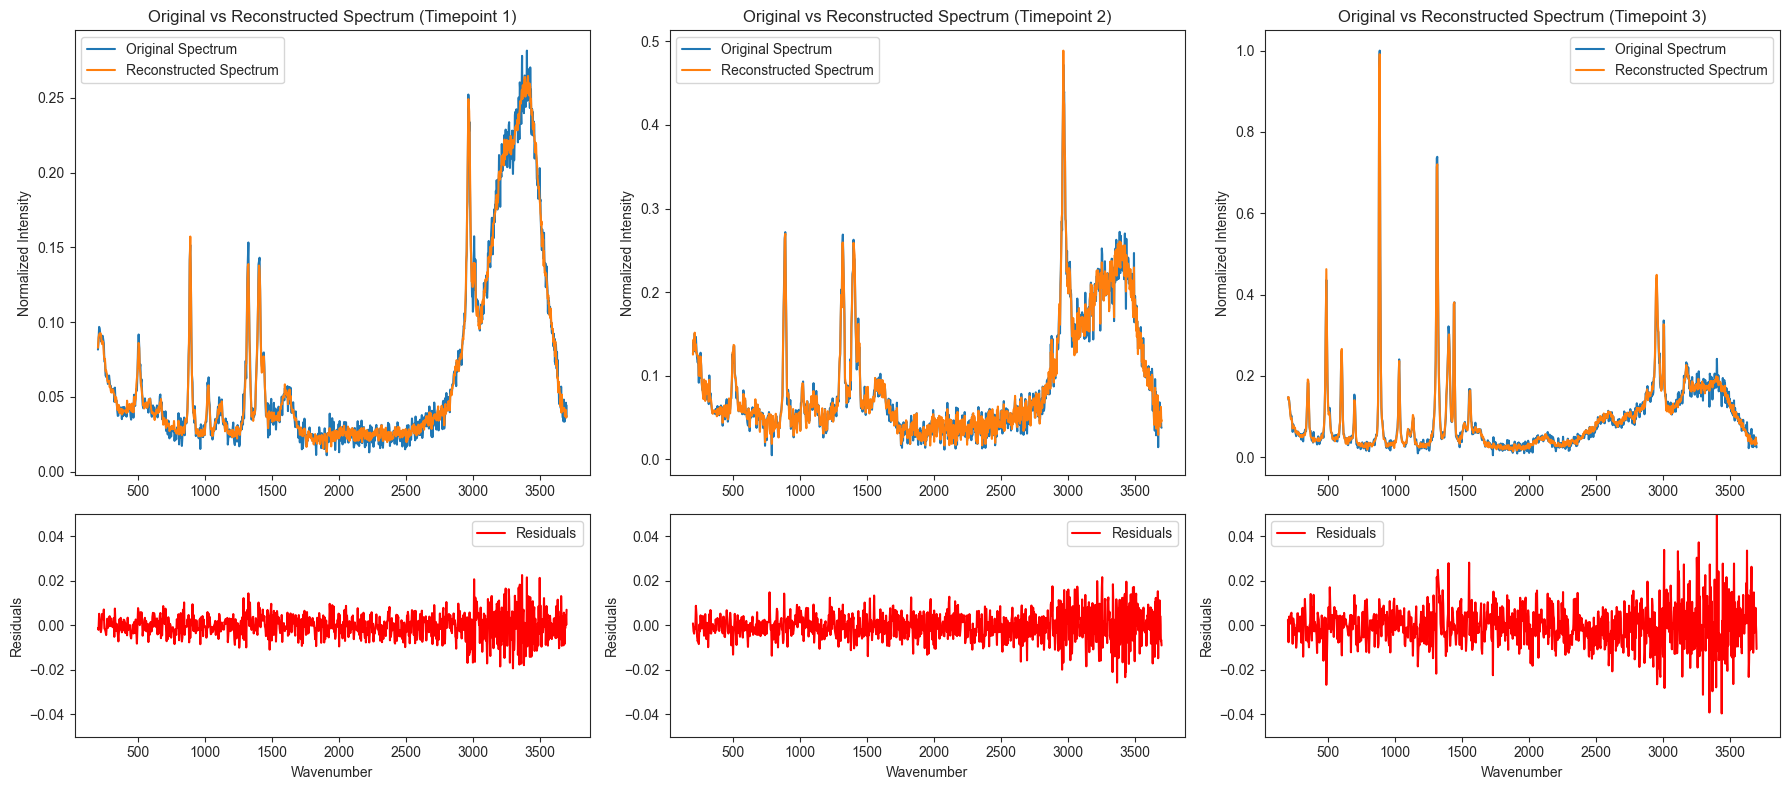

In [22]:

# Define indices of spectra to evaluate for three timepoints
datapoint_indices = [specific_time_indexes[0], specific_time_indexes[1], specific_time_indexes[2]]

# Reconstruct the spectra using the fitted NMF model
spectra_reconstructed = NMF_pipeline.named_steps['nmf'].inverse_transform(W)

# Create a 2x3 plot
fig, axs = plt.subplots(2, 3, figsize=(18, 8), gridspec_kw={'height_ratios': [2, 1]})

for i, datapoint_index in enumerate(datapoint_indices):
    # Original and reconstructed spectra for the specified datapoint
    original_spectrum = spectra_dataset_svd_filtered_normalized.iloc[datapoint_index, :]
    reconstructed_spectrum = spectra_reconstructed[datapoint_index, :]

    # Calculate residuals
    residuals = original_spectrum - reconstructed_spectrum

    # Plot the original and reconstructed spectra
    axs[0, i].plot(wavenumbers, original_spectrum, label='Original Spectrum')
    axs[0, i].plot(wavenumbers, reconstructed_spectrum, label='Reconstructed Spectrum')
    axs[0, i].set_title(f'Original vs Reconstructed Spectrum (Timepoint {i+1})')
    axs[0, i].set_ylabel('Normalized Intensity')
    axs[0, i].legend()

    # Plot residuals
    axs[1, i].plot(wavenumbers, residuals, label='Residuals', color='red')
    axs[1, i].set_ylim(-0.05, 0.05)
    axs[1, i].set_xlabel('Wavenumber')
    axs[1, i].set_ylabel('Residuals')
    axs[1, i].legend()

# Adjust layout
plt.tight_layout()
plt.show()


**Insights:** 

- There is a match between the reconstructed and original spectra. 

- The residuals have no defined structure.
- The magnitude of residuals is below 5%. 

## 9. Conclusions 

- By applying hierarchical clustering and a series of scores, the optimum number of chemical signatures from the dataset was determined to be 3. The result was further validated by visual inspection on a 2-dimensional reduced representation of de data.
- 3 components were extracted from the dataset by NMF which are the primary chemical signatures describing the chemical species involved in the crystallization process.
- The reduced representation obtained from NMF (weights) revealed insights about the behavior of each component throughout the crystallization process.

- Both, the extracted components and weights are highly interpretable results. 

- Although this notebook is focused on the data analysis, the role of a domain expert plays a key role in the interpretation of the results, as it was described in the original paper.

## 10. References

- Urquidi, Oscar, et al. "In situ optical spectroscopy of crystallization: One crystal nucleation at a time." Proceedings of the National Academy of Sciences 119.16 (2022): e2122990119.


- Data source: https://doi.org/10.1073/pnas.2122990119)